# Sentiment Analysis on Tweets
This notebook demonstrates the process of performing sentiment analysis on a dataset of tweets. The objective is to classify tweets into one of three categories: positive, negative, or neutral sentiment.

## 1. Importing Libraries
In this section, we import all the necessary libraries for data processing, visualization, and model building. This includes libraries like `pandas`, `seaborn`, `nltk` for natural language processing, and TensorFlow/Keras for building neural networks.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

## 2. Download NLTK Data
Here, we download essential datasets from the Natural Language Toolkit (NLTK), including:

* **Punkt**: Used for tokenization.
* **Stopwords**: A collection of common words that should be excluded from analysis.
* **WordNet**: Used for lemmatization, helping in reducing words to their root form.

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## 3. Load and Preprocess Data
Here, we load our dataset into a Pandas DataFrame and perform some initial preprocessing:

* **Drop unnecessary columns**: We remove the `selected_text` column as it’s not needed for our analysis.
* **Visualize sentiment distribution**: We use a count plot to show the distribution of sentiments in the dataset.
* **Handle missing data**: Any missing values are dropped, and we create new features like `text_length` and `word_count` to help in understanding the data better.

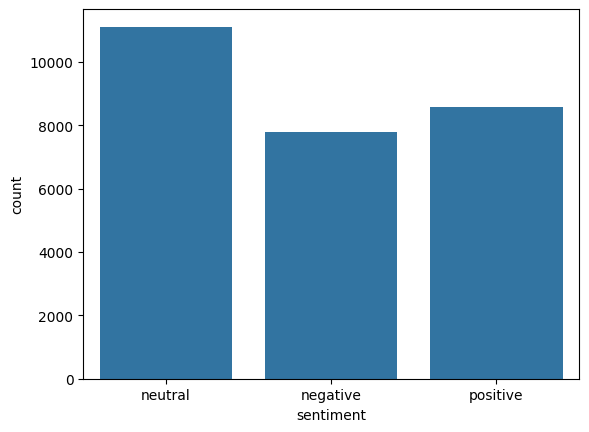

In [3]:
df = pd.read_csv('./input/train.csv')

# Drop unnecessary columns
df.drop(columns=['selected_text'], inplace=True)

# Display the distribution of sentiments
sns.countplot(x='sentiment', data=df)
plt.show()

# Handle missing data
df.dropna(inplace=True)
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

## 4. Text Preprocessing
This section covers the preprocessing of text data:

* **Lowercasing**: Convert all text to lowercase to ensure uniformity.
* **Contraction Expansion**: Expand common contractions (e.g., `won't` to `will not`) for better tokenization.
* **Removal of Special Characters**: Remove punctuation and non-alphanumeric characters.
* **Tokenization and Lemmatization**: Tokenize the text into words and lemmatize them (convert words to their base form). We also remove stopwords to reduce noise in the data.

The `preprocess_text` function handles these steps and is applied to the text data.

In [4]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    text = re.sub(r'[^a-z0-9\s]', '', text)

    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

# Apply preprocessing to the text data
df['processed_text'] = df['text'].apply(preprocess_text)


## 5. Data Splitting
In this step, we split our dataset into training and validation sets using an 70-30 split. The training set is used to train the model, while the validation set helps in assessing the model's performance.

In [5]:
X = df['processed_text']
y = df['sentiment']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=50)

## 6. Text Vectorization
Text data needs to be converted into numerical form before feeding it into a machine learning model. We use the TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer to transform the text data into vectors of numerical features.

In [6]:
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

## 7. Label Binarization
Since our target variable (sentiment) is categorical, we need to convert it into a numerical format. We use `LabelBinarizer` to perform one-hot encoding of the sentiment labels.

In [7]:
label_binarizer = LabelBinarizer()
y_train_binarized = label_binarizer.fit_transform(y_train)
y_val_binarized = label_binarizer.transform(y_val)

## 8. Model Definition
Here, we define a neural network model using TensorFlow/Keras:

* **Input Layer**: The input layer has 100 units and uses the ReLU activation function.
* **Hidden Layers**: Two hidden layers with 25 and 10 units, respectively, each followed by a dropout layer to prevent overfitting.
* **Output Layer**: The output layer has 3 units (corresponding to the 3 sentiment classes) and uses the softmax activation function for multiclass classification.


In [8]:
model = Sequential([
    Dense(units=100, activation='relu', input_shape=(X_train_vectorized.shape[1],)),
    Dropout(0.3),
    Dense(units=25, activation='relu'),
    Dropout(0.3),
    Dense(units=10, activation='relu'),
    Dropout(0.3),
    Dense(units=3, activation='softmax')
])

model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 9. Model Training
We compile and train the model using the categorical crossentropy loss function and the Adam optimizer. The model is trained over 10 epochs, and its performance is evaluated using the validation set.

In [9]:
history = model.fit(X_train_vectorized, y_train_binarized, epochs=10, validation_data=(X_val_vectorized, y_val_binarized))

Epoch 1/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5108 - loss: 0.9618 - val_accuracy: 0.6508 - val_loss: 0.7883
Epoch 2/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.7105 - loss: 0.6797 - val_accuracy: 0.6658 - val_loss: 0.7840
Epoch 3/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.8164 - loss: 0.5072 - val_accuracy: 0.6412 - val_loss: 0.9252
Epoch 4/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.8625 - loss: 0.4048 - val_accuracy: 0.6514 - val_loss: 1.0392
Epoch 5/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.8968 - loss: 0.3266 - val_accuracy: 0.6417 - val_loss: 1.1387
Epoch 6/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9123 - loss: 0.2840 - val_accuracy: 0.6487 - val_loss: 1.2826
Epoch 7/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9316 - loss: 0.2271 - val_accuracy: 0.6446 - val_loss: 1.3689
Epoch 8/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9341 - loss: 0.2233 - 

## 10. Plotting Accuracy and Loss
Finally, we visualize the model’s training process:

* **Accuracy vs Epochs**: A plot showing how the training and validation accuracy change over the epochs.
* **Loss vs Epochs**: A plot showing the changes in training and validation loss over the epochs.
These plots help in understanding how well the model is learning and if there is any overfitting or underfitting.

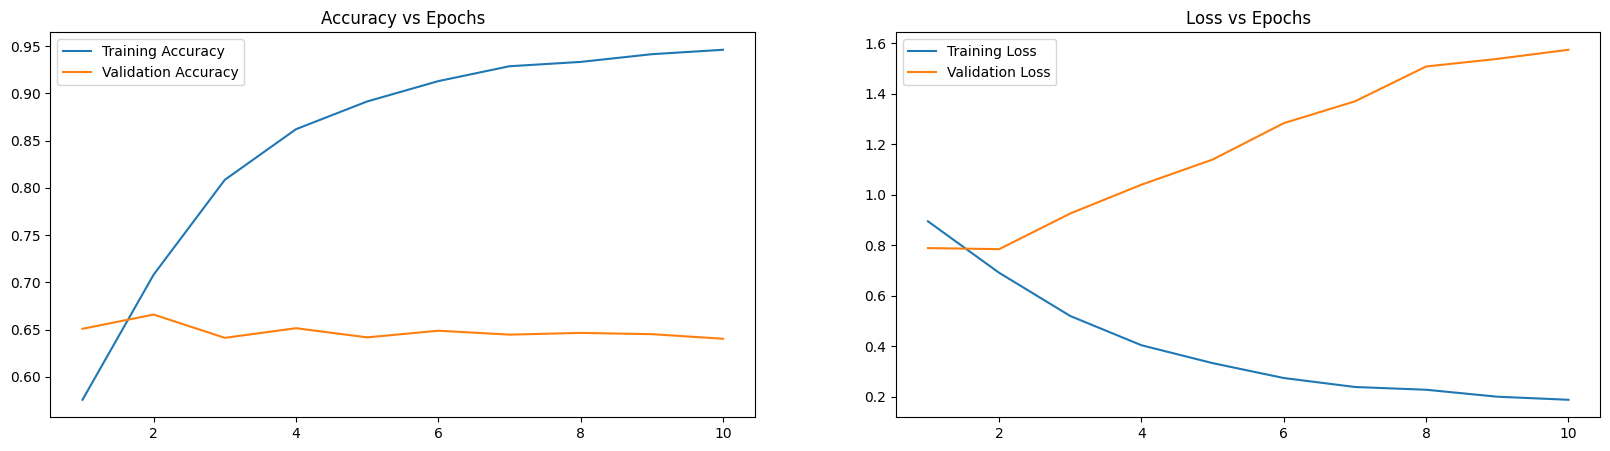

In [10]:
epochs_range = np.arange(1, 11)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Plotting Accuracy
sns.lineplot(x=epochs_range, y=accuracy, ax=ax[0], label="Training Accuracy")
sns.lineplot(x=epochs_range, y=val_accuracy, ax=ax[0], label="Validation Accuracy")
ax[0].set_title('Accuracy vs Epochs')

# Plotting Loss
sns.lineplot(x=epochs_range, y=loss, ax=ax[1], label="Training Loss")
sns.lineplot(x=epochs_range, y=val_loss, ax=ax[1], label="Validation Loss")
ax[1].set_title('Loss vs Epochs')

plt.show()

## Conclusions
This notebook provides a comprehensive approach to performing sentiment analysis on tweets, starting from data preprocessing to model evaluation. The steps outlined can be adapted to similar text classification tasks involving social media data.